# Workbook information

Replicating the NLP deep learning model used to classify sentences which appear in sequential order within a scientific report abstract (https://arxiv.org/abs/1710.06071) in order to read the key information faster.

The dataset used is called PubMed 200k RCT - 200,000 abstracts of randomised controlled trials (RCT) totalling 2.3 million sentences. Each sentence is labelled with their role in the abstract

In [2]:
# Importing the helper_functions file
import os

if not os.path.exists('helper_functions.py'):
  !wget https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
else:
  print("[INFO] 'helper_functions_TF.py' already exists, skipping download.")
     

--2023-06-12 12:09:06--  https://raw.githubusercontent.com/DavAll22/Extra-Code/main/helper_functions_TF.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13751 (13K) [text/plain]
Saving to: ‘helper_functions_TF.py’

helper_functions_TF 100%[===================>]  13.43K  --.-KB/s    in 0.001s  

2023-06-12 12:09:06 (24.1 MB/s) - ‘helper_functions_TF.py’ saved [13751/13751]



# Downloading the dataset

In [3]:
! git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.19 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


README file shows:
* 20k dataset is a subset of 200k dataset
* Separate datasets for where numbers have been replaced with an @
* 200k Train dataset compressed to .zip format (github file size limit is 100MB)

Will use 20k dataset with the numbers replaced to keep experiments fast

In [4]:
# Check what files are in the PubMed_20k dataset
! ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# Saving path directory
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Check all file names in target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

In [7]:
# Visualising the data

# Function to read the document lines
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list

  Args:
      filename: a string containing the traget filepath to read
  
  Returns:
      A list of strings with 1 string per line from the traget filename
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """

  with open(filename, 'r') as f:
    return f.readlines()

In [8]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

Text requires preprocessing
* If line starts with ###, mark as abstract ID and the beginning of a new abstract
  * keep count of the number of lines in the sample
* If line begins with \n, mark it as the end of an abstract sample
  * keep count of the total lines in a sample
* Record the text before the \t as the label of the line
* Record the text after the \t as the text of the line
* Return all the lines as a list of dictionaries containing the above details

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 593 ms, sys: 85.4 ms, total: 678 ms
Wall time: 908 ms


(180040, 30212, 30135)

In [12]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [13]:
# Converting dictionaries into pandas DataFrames for visualisation
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


## Analysing the Dataframe

In [14]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

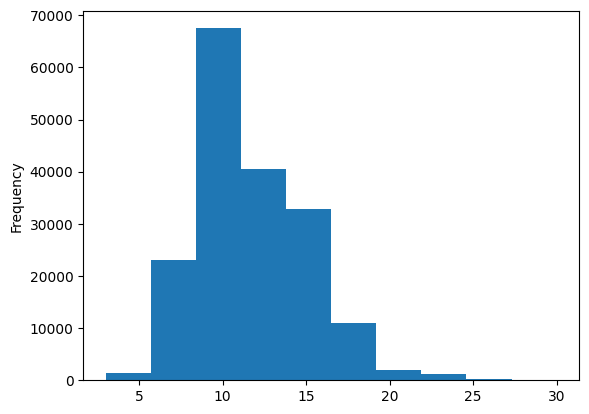

In [15]:
train_df.total_lines.plot.hist();

In [16]:
# Convert abstract text lines into lists for inputs to the model
train_sentences = train_df["text"].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [17]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## One-Hot encoding and Label encoded labels

Both methods for numerically encoding the labels (classes).

Use One-Hot encoded labels for CategoricalCrossentropy() loss function in modelling - also used for creating the dataset using tf.data API.

Label encoded labels assigns a number to the class (label) that the text belongs to - created the ground truth class values.

In [18]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [19]:
# Extract labels (target columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [20]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Model 0: Baseline

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [22]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [23]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [24]:
# Import calculate_results helper function
from helper_functions_TF import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

# Deep Sequence data preparation

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [26]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

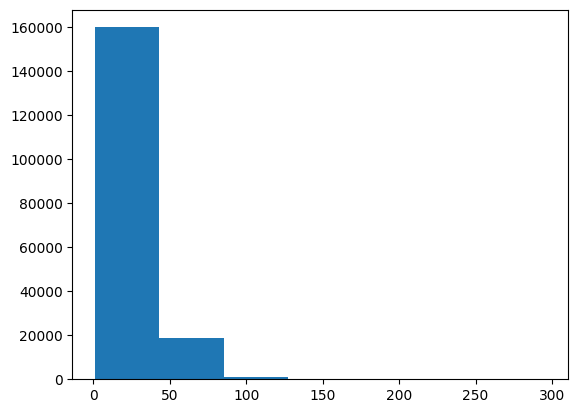

In [27]:
# Sentence length distribution
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [28]:
# How long of a sentence covers 95% of the legnths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# Maximum sentence length in the training set
max(sent_lens)

296

## Text Vectorizer

In [30]:
# How many words in the vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000 # Vocabulary size for 20k dataset

In [31]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences (95% percentile value)

In [32]:
# adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [33]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized test:\n{text_vectorizer([target_sentence])}')

Text:
a candidate tetravalent dengue vaccine is being assessed in three clinical trials involving more than @,@ children between the ages of @ and @ years in asian-pacific and latin american countries .

Length of text: 32

Vectorized test:
[[    8  4127 11369  4597   497    20   571   113     5   134    47   233
   1267    69    42   109    30     2  1588     4     3    64     5 41002
      3 11121  1035  1214     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [34]:
# How many words in the training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [35]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

## Embedding

In [36]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),# Length of vocabulary
                               output_dim=128,# Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding usign the random sentence from above
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
a candidate tetravalent dengue vaccine is being assessed in three clinical trials involving more than @,@ children between the ages of @ and @ years in asian-pacific and latin american countries .

Sentence after vectorization (before embedding):
[[    8  4127 11369  4597   497    20   571   113     5   134    47   233
   1267    69    42   109    30     2  1588     4     3    64     5 41002
      3 11121  1035  1214     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.0498667   0.02273277  0.03777737 ...  0.00946945  0.02458337
   -0.02239652]
  [-0.00304168  0.01071216  0.03610578 ... -0.00900965 -0.01374567
    0.01952438]
  [-0.02463805  0.02030531 -0.01869134 ...  0.01780566  0.04810292
    0.00821495]
  ...
  [-0.03819766 -0.0116768   0.01134966 ... -0.01538246 -0.02722002
    0.03076705]
  [-0.03819766 

## Creating the datasets

Using tf.data API for faster loading of datasets.
* Using batching and prefetching

In [37]:
# Turn the data into Tensorflow Datasets API
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embedding

In [39]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize tezt inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of the feature vector
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy', # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [40]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

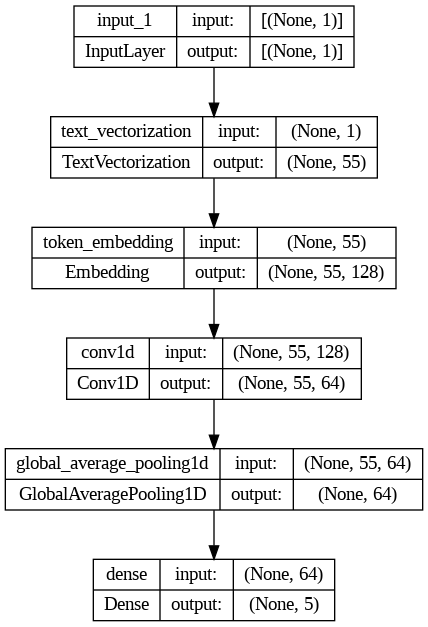

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, show_shapes=True)

In [42]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only fit on 10% of batches for faster training time

Epoch 1/3
562/562 [==============================] - 44s 59ms/step - loss: 0.9123 - accuracy: 0.6420 - val_loss: 0.6790 - val_accuracy: 0.7424
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.6560 - accuracy: 0.7574 - val_loss: 0.6273 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6147 - accuracy: 0.7747 - val_loss: 0.5941 - val_accuracy: 0.7842


In [43]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.5975 - accuracy: 0.7866


[0.5974655151367188, 0.7866410613059998]

In [44]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[4.5107633e-01, 1.1872306e-01, 8.1606828e-02, 3.2319912e-01,
        2.5394736e-02],
       [4.6910638e-01, 2.4367104e-01, 1.4377187e-02, 2.6478735e-01,
        8.0579622e-03],
       [1.5505248e-01, 7.6608476e-03, 2.1684186e-03, 8.3509111e-01,
        2.7226422e-05],
       ...,
       [6.9667408e-06, 5.7178998e-04, 8.6748443e-04, 4.3878381e-06,
        9.9854940e-01],
       [6.3387565e-02, 5.1157647e-01, 9.3991011e-02, 6.6192336e-02,
        2.6485258e-01],
       [1.4879899e-01, 6.7457318e-01, 5.6620300e-02, 4.9427450e-02,
        7.0579991e-02]], dtype=float32)

In [45]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.66410697735999,
 'precision': 0.7834145552652586,
 'recall': 0.7866410697735999,
 'f1': 0.7843351459388148}

# Model 2: Feature extraction with pretrained token embedding (Transfer Learning)

In [47]:
# Download pretrained Tensorflow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [48]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the current study , the finest trial ( comparison of safety and primary patency between the fusion bioline heparin-coated vascular graft and exxcel soft eptfe ) , was designed to assess the clinical outcome of heparin-coated and standard vascular grafts in a prospective , randomized , controlled , multicenter trial .

Sentence after embedding:
[-0.0536772  -0.06638596 -0.03393097 -0.0494362   0.02190831 -0.06195455
  0.07786992 -0.04123293  0.0501084  -0.00472421  0.08010545 -0.0074177
  0.0602144   0.00821519  0.00819819 -0.01906332 -0.07542912  0.00776052
  0.01357699 -0.01925023  0.0464182   0.02019988 -0.05859593  0.03078423
  0.07469226 -0.07029801 -0.02960965  0.08360664 -0.03390662  0.06358338] (truncated output)...

Length of sentence embedding:
512


In [49]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation='relu')(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here is you wanted to
outputs = layers.Dense(5, activation='softmax')(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [50]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


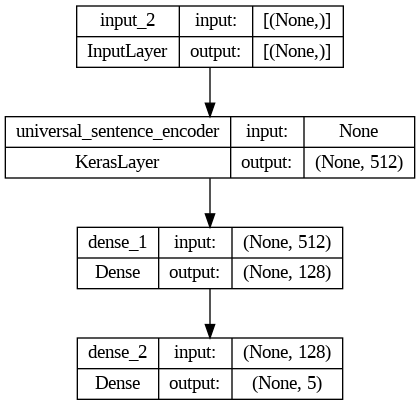

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes=True)

In [52]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 15ms/step - loss: 0.9165 - accuracy: 0.6534 - val_loss: 0.7967 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7679 - accuracy: 0.7011 - val_loss: 0.7544 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7514 - accuracy: 0.7129 - val_loss: 0.7378 - val_accuracy: 0.7128


In [53]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 14ms/step - loss: 0.7407 - accuracy: 0.7139


[0.7407281994819641, 0.7139216065406799]

In [54]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 15s 16ms/step


array([[4.2622250e-01, 3.5099131e-01, 2.0997592e-03, 2.1369338e-01,
        6.9930246e-03],
       [3.4562549e-01, 4.7068259e-01, 3.9502354e-03, 1.7711586e-01,
        2.6258288e-03],
       [2.5162804e-01, 1.0813849e-01, 1.4584794e-02, 5.9307438e-01,
        3.2574348e-02],
       ...,
       [1.6288054e-03, 5.5841543e-03, 5.1977471e-02, 9.0984855e-04,
        9.3989974e-01],
       [4.3540807e-03, 5.3918086e-02, 1.9820519e-01, 1.5323273e-03,
        7.4199033e-01],
       [2.0889796e-01, 2.4430951e-01, 4.9935973e-01, 6.5921606e-03,
        4.0840711e-02]], dtype=float32)

In [55]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [56]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.39216205481266,
 'precision': 0.7139478889852007,
 'recall': 0.7139216205481266,
 'f1': 0.7109006253658576}

# Character-level Tokenizer and Embedding

Prior embedding was a custom token embedding and pre-trained token embedding.

Character-level embedding works on sequences split into characters, not words like before.

In [57]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character-level sequence into characters
split_chars(random_training_sentence)

't h e   c u r r e n t   s t u d y   ,   t h e   f i n e s t   t r i a l   (   c o m p a r i s o n   o f   s a f e t y   a n d   p r i m a r y   p a t e n c y   b e t w e e n   t h e   f u s i o n   b i o l i n e   h e p a r i n - c o a t e d   v a s c u l a r   g r a f t   a n d   e x x c e l   s o f t   e p t f e   )   ,   w a s   d e s i g n e d   t o   a s s e s s   t h e   c l i n i c a l   o u t c o m e   o f   h e p a r i n - c o a t e d   a n d   s t a n d a r d   v a s c u l a r   g r a f t s   i n   a   p r o s p e c t i v e   ,   r a n d o m i z e d   ,   c o n t r o l l e d   ,   m u l t i c e n t e r   t r i a l   .'

In [58]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [59]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

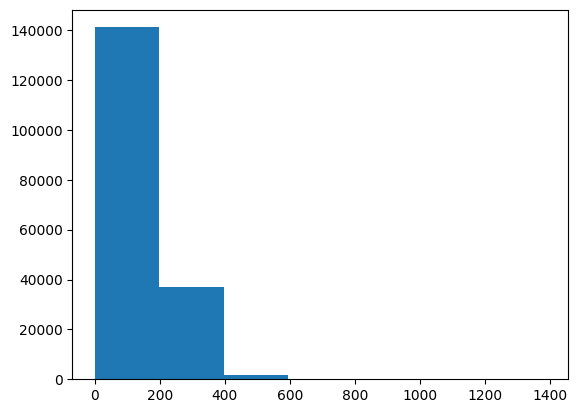

In [60]:
# Check thye distribution of the sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [61]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [62]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [63]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize='lower_and_strip_punctuation',
                                    name='char_vectorizer')

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
s c a r - t o - m y o c a r d i u m   c o n t r a s t - t o - n o i s e   r a t i o   (   c n r   )   ,   s c a r - t o - b l o o d   c n r   ,   s c a r   s i z e   a n d   i m a g e   q u a l i t y   w e r e   a s s e s s e d   .

Length of chars: 99

Vectorized chars:
[[ 9 11  5  8  3  7 15 19  7 11  5  8 10  4 16 15 11  7  6  3  8  5  9  3
   3  7  6  7  4  9  2  8  5  3  4  7 11  6  8  9 11  5  8  3  7 22 12  7
   7 10 11  6  8  9 11  5  8  9  4 25  2  5  6 10  4 15  5 18  2 26 16  5
  12  4  3 19 20  2  8  2  5  9  9  2  9  9  2 10  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

In [66]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
s c a r - t o - m y o c a r d i u m   c o n t r a s t - t o - n o i s e   r a t i o   (   c n r   )   ,   s c a r - t o - b l o o d   c n r   ,   s c a r   s i z e   a n d   i m a g e   q u a l i t y   w e r e   a s s e s s e d   .

Embedded chars (after vectorization and embedding):
[[[ 0.029826    0.02714497 -0.04648566 ... -0.003878    0.03474578
   -0.00030829]
  [ 0.00470996  0.02290321  0.04735558 ...  0.03743584 -0.02039975
   -0.0298339 ]
  [-0.03611154  0.00396717  0.03917101 ...  0.0373057  -0.04505508
   -0.00096657]
  ...
  [-0.00254788 -0.04190712 -0.04602544 ... -0.01871803 -0.03677645
    0.01800427]
  [-0.00254788 -0.04190712 -0.04602544 ... -0.01871803 -0.03677645
    0.01800427]
  [-0.00254788 -0.04190712 -0.04602544 ... -0.01871803 -0.03677645
    0.01800427]]]

Character embedding shape: (1, 290, 25)


# Model 3: Conv1D & character-level embedding

In [67]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

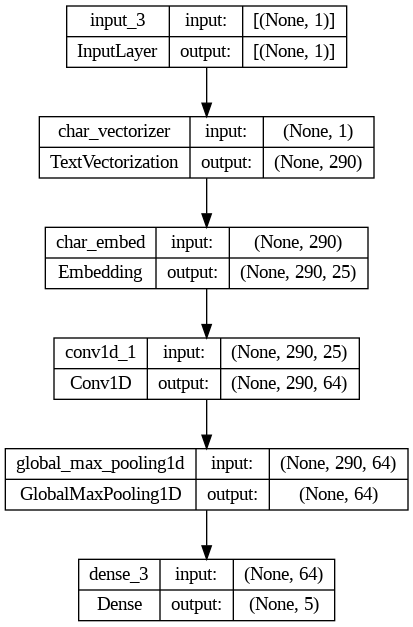

In [69]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, show_shapes=True)

In [70]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 6s 8ms/step - loss: 1.2441 - accuracy: 0.5016 - val_loss: 1.0139 - val_accuracy: 0.5967
Epoch 2/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9853 - accuracy: 0.6024 - val_loss: 0.9232 - val_accuracy: 0.6373
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.9160 - accuracy: 0.6438 - val_loss: 0.8587 - val_accuracy: 0.6689


In [72]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.8803 - accuracy: 0.6577


[0.8802849650382996, 0.6576526165008545]

In [73]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.1934585 , 0.3108561 , 0.15657547, 0.2599131 , 0.07919688],
       [0.15853022, 0.6097102 , 0.02431071, 0.14833888, 0.05910999],
       [0.23900762, 0.23529273, 0.23655397, 0.23793954, 0.05120611],
       ...,
       [0.03264479, 0.05934546, 0.16356148, 0.07827337, 0.6661749 ],
       [0.01739914, 0.03730353, 0.29188293, 0.01456898, 0.6388454 ],
       [0.28421488, 0.4570635 , 0.1340091 , 0.10259002, 0.02212251]],
      dtype=float32)

In [74]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 0, ..., 4, 4, 1])>

In [75]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.76525883754799,
 'precision': 0.6494460772544868,
 'recall': 0.6576525883754799,
 'f1': 0.6480731581066376}

# Model 4: Hybrid Embedding Layer

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs) # USE model token embeddings (Model_2)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

#2. Setup character inputs/outputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_and_char_embeddings')

In [77]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

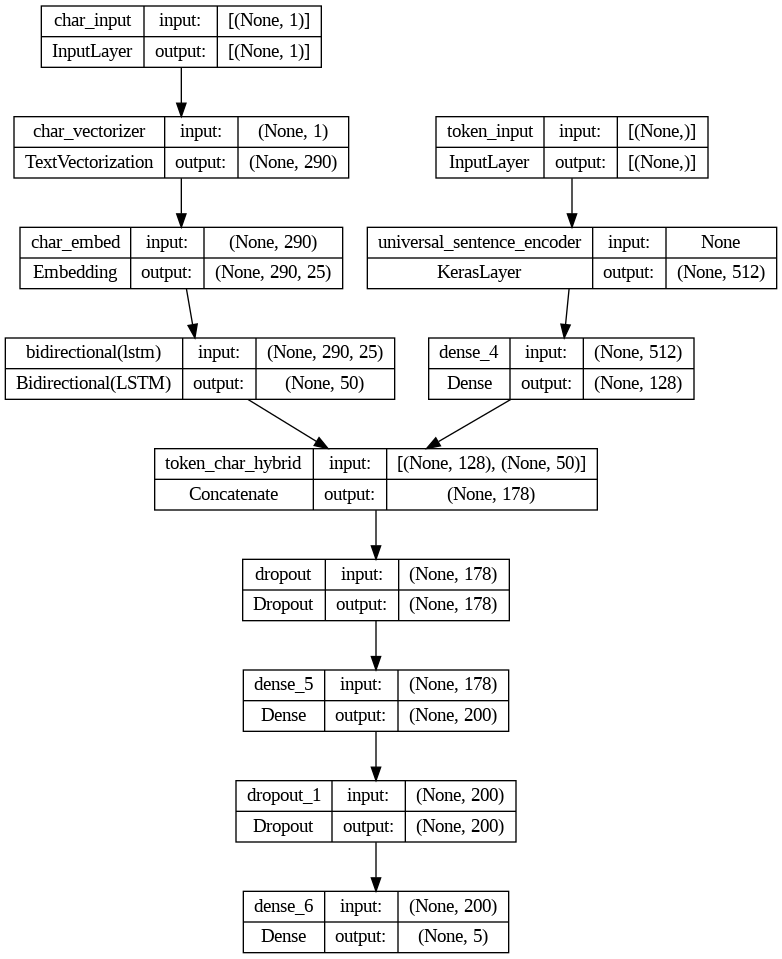

In [78]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [80]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 35ms/step - loss: 0.9708 - accuracy: 0.6138 - val_loss: 0.7840 - val_accuracy: 0.6968
Epoch 2/3
562/562 [==============================] - 17s 31ms/step - loss: 0.7967 - accuracy: 0.6928 - val_loss: 0.7121 - val_accuracy: 0.7367
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7666 - accuracy: 0.7060 - val_loss: 0.6919 - val_accuracy: 0.7407


In [83]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6965 - accuracy: 0.7349


[0.69646817445755, 0.7348735332489014]

In [84]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 18ms/step


array([[4.11516875e-01, 3.60960573e-01, 4.15910687e-03, 2.14227453e-01,
        9.13598947e-03],
       [2.91541398e-01, 5.61129928e-01, 2.76249298e-03, 1.42651498e-01,
        1.91470049e-03],
       [3.25159520e-01, 1.68954089e-01, 7.12185204e-02, 3.74231040e-01,
        6.04367927e-02],
       ...,
       [3.13579338e-04, 7.27955764e-03, 4.75962125e-02, 1.04996871e-04,
        9.44705606e-01],
       [9.31390375e-03, 6.59164190e-02, 1.86183110e-01, 4.99533908e-03,
        7.33591199e-01],
       [4.74702746e-01, 3.63911778e-01, 1.09416254e-01, 3.06646358e-02,
        2.13046689e-02]], dtype=float32)

In [85]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [86]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.4873560174765,
 'precision': 0.7367053302380686,
 'recall': 0.734873560174765,
 'f1': 0.7332477592744605}

# Model 5: Feature Engineering

## Feature Engineering

Encoding our own knowledge of the dataset in a numerical way to give the model more info about the samples.
  * Sentences appear in order, not sequentially like in the data given (i.e. objectives 1st, conclusions last)
  * Can encode the order of a set of sequences in the abstract using the sentence features found in the function `preprocess_text_with_numbers()` , like `line_number` and `total_lines`
    * We can find out where in the abstract the sentence is and predict what the label could be by position alone since we don't have sentence labels at test

In [92]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [86]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

Majority of abstracts have 15 lines or less

In [87]:
# Use TF to create one-hot-encoded tensors of the 'line_number' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [88]:
# Check one-hot encoded 'line_number' feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [89]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

In [90]:
# Check the coverage of a total_lines value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [91]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20) # depth is the total_lines value
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Model building (Tribrid)

In [93]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype='string', name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs) # Model_2
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Character Inputs
char_inputs = layers.Input(shape=(1,), dtype='string', name='char_inputs')
char_vectors = char_vectorizer(char_inputs) # Model_3
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name='line_number_input')
x = layers.Dense(32, activation='relu')(line_number_inputs) # Model_5 (above)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name='total_lines_input')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid model
combined_embeddings = layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,
                                                                              char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name='token_char_positional_embedding')([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation='softmax', name='output_layer')(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [94]:
# Get a summary of our token, char and positional embedding model
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

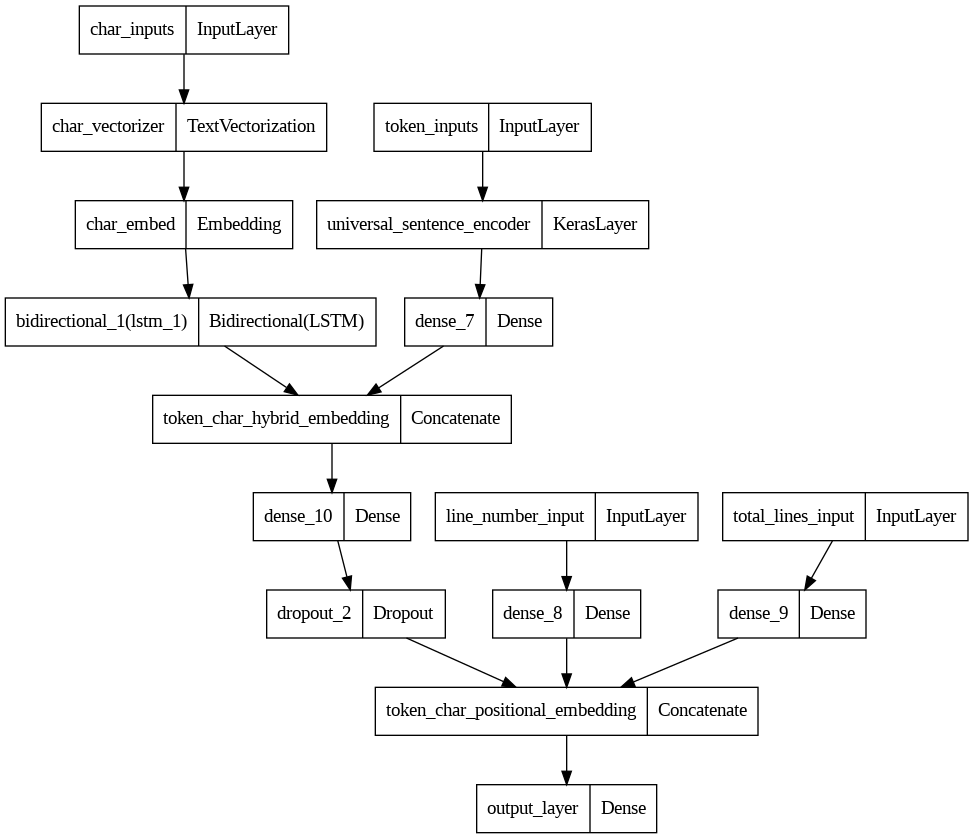

In [95]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [96]:
# Check which layers of the model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f45386a49a0> True
<keras.engine.input_layer.InputLayer object at 0x7f4526ef3580> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f44c8f012a0> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f45b077d090> False
<keras.layers.core.embedding.Embedding object at 0x7f44c8f42290> True
<keras.layers.core.dense.Dense object at 0x7f4527e9f6d0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f4527ef5ed0> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f452755d8d0> True
<keras.engine.input_layer.InputLayer object at 0x7f44d054c550> True
<keras.engine.input_layer.InputLayer object at 0x7f4527e9ffd0> True
<keras.layers.core.dense.Dense object at 0x7f45275e9e10> True
<keras.layers.core.dense.Dense object at 0x7f461cb22b90> True
<keras.layers.core.dense.Dense object at 0x7f4527571cc0> True
<keras.layers.regularization.dropout.Dropout object at 0x7f45385a4a60> True
<keras.layers

In [97]:
# Compile token, char, positional embedding model:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [98]:
# Create training and validation datasets (all 4 kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [99]:
# Fit the token, char and positional embedding model:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1*len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 45ms/step - loss: 1.1017 - accuracy: 0.7220 - val_loss: 0.9821 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.9674 - accuracy: 0.8151 - val_loss: 0.9499 - val_accuracy: 0.8261
Epoch 3/3
562/562 [==============================] - 22s 40ms/step - loss: 0.9511 - accuracy: 0.8236 - val_loss: 0.9365 - val_accuracy: 0.8318


In [100]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[0.4901929 , 0.10949966, 0.01172497, 0.3676289 , 0.02095359],
       [0.52655923, 0.10565992, 0.05143499, 0.30662683, 0.00971902],
       [0.2753814 , 0.10334726, 0.14745405, 0.3887599 , 0.0850574 ],
       ...,
       [0.03332643, 0.12193766, 0.03523235, 0.03054985, 0.77895373],
       [0.02723929, 0.3103358 , 0.0741178 , 0.02628132, 0.5620258 ],
       [0.27022362, 0.52857506, 0.09310475, 0.05174291, 0.0563537 ]],
      dtype=float32)

In [101]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [102]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.34105653382761,
 'precision': 0.8319356483746646,
 'recall': 0.8334105653382762,
 'f1': 0.8320420988628395}

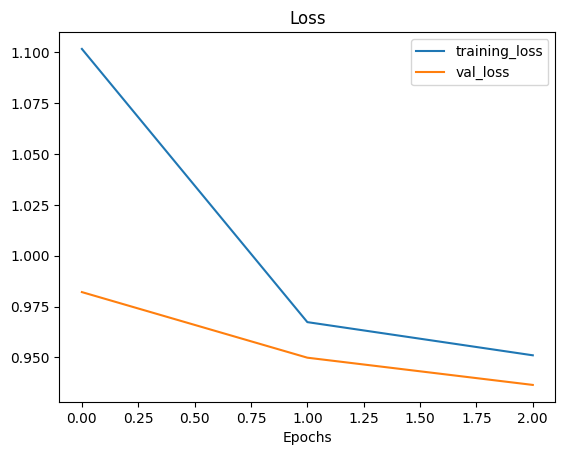

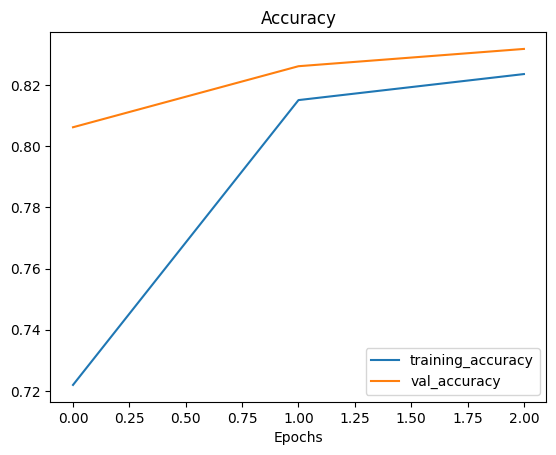

In [113]:
from helper_functions_TF import plot_loss_curves
plot_loss_curves(history_model_5)

# Compare model results

In [103]:
# Combine model results into a Dataframe
all_model_results = pd.DataFrame({'baseline': baseline_results,
                                  'custom_token_embed_conv1d': model_1_results,
                                  'pretrained_token_embed': model_2_results,
                                  'custom_char_embed_conv1d': model_3_results,
                                  'hybrid_char_token_embed': model_4_results,
                                  'tribrid_pos_char_token_embed': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.664107,0.783415,0.786641,0.784335
pretrained_token_embed,71.392162,0.713948,0.713922,0.710901
custom_char_embed_conv1d,65.765259,0.649446,0.657653,0.648073
hybrid_char_token_embed,73.487356,0.736705,0.734874,0.733248
tribrid_pos_char_token_embed,83.341057,0.831936,0.833411,0.832042


In [104]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

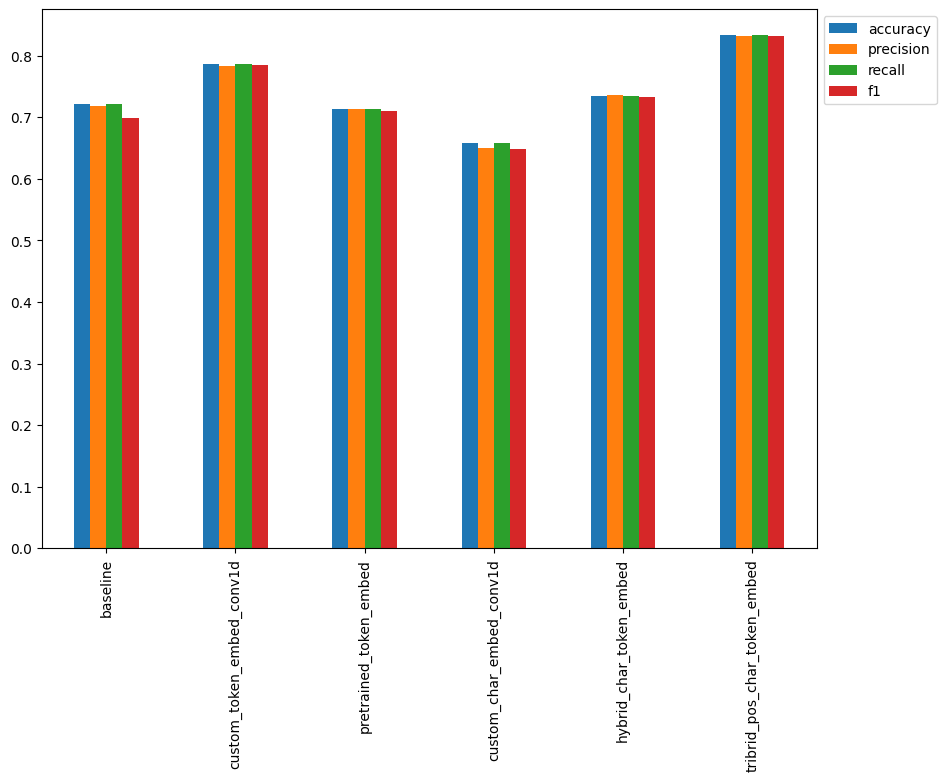

In [105]:
# Plot and compare all the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

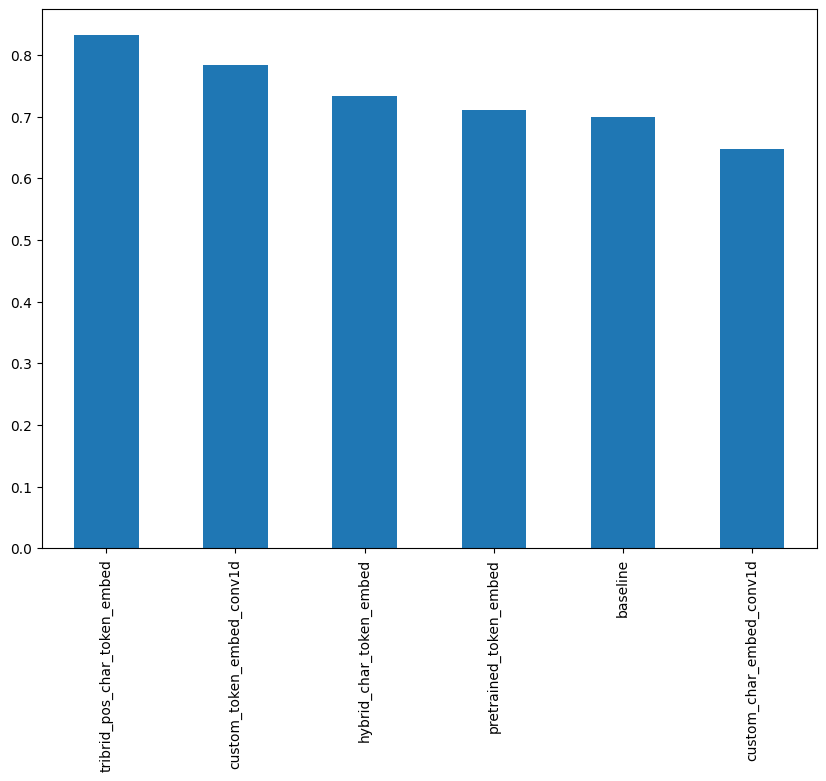

In [106]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Evaluating on the test dataset

In [109]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [153]:
# Make predictions on the test dataset
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                   verbose=1)
test_preds = test_pred_probs.argmax(axis=1)
test_preds[:10]

942/942 [==============================] - 17s 18ms/step


array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])

In [154]:
# Evaluate model test predictions
model_5_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=test_preds)
model_5_test_results

{'accuracy': 82.95337647254023,
 'precision': 0.8277862467528799,
 'recall': 0.8295337647254023,
 'f1': 0.828137051412802}

In [163]:
test_labels_encoded[:10], test_preds[:10], class_names.tolist()

(array([0, 4, 4, 4, 4, 4, 4, 1, 1, 0]),
 array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0]),
 ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

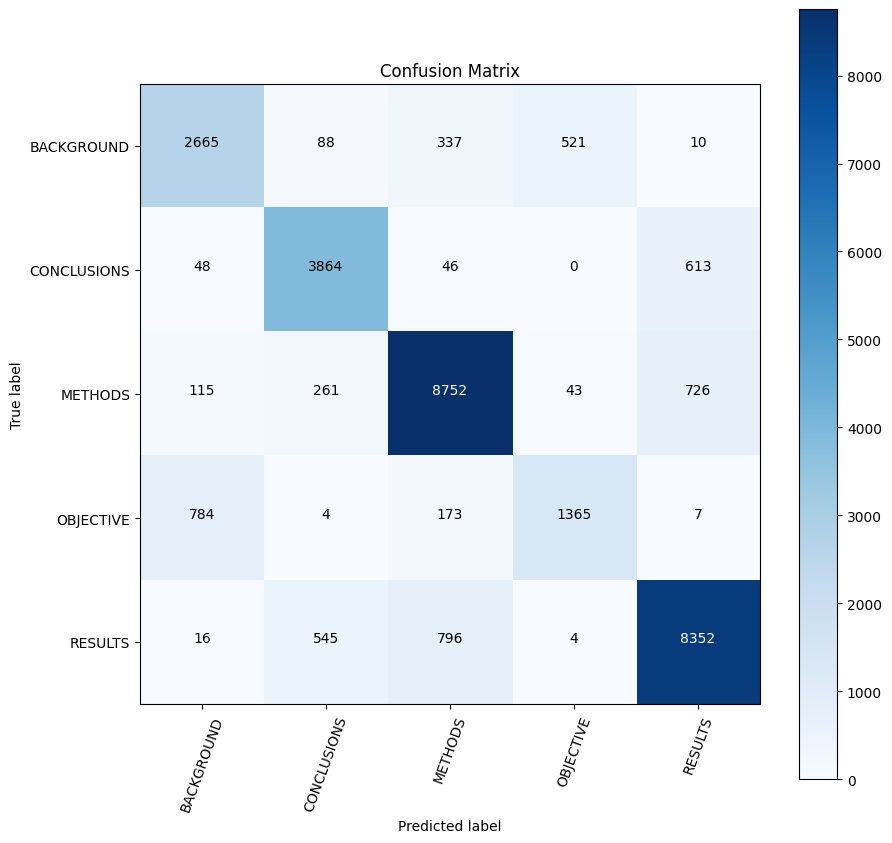

In [164]:
from helper_functions_TF import make_confusion_matrix

make_confusion_matrix(y_true=test_labels_encoded,
                      y_pred=test_preds,
                      classes=class_names.tolist(),
                      figsize=(10, 10),
                      text_size=10)

# Finding most wrong predictions on best performing model

In [115]:
%%time
# get list of class names of test predictions
# converts prediction one-hot label to the class label
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

CPU times: user 18.3 s, sys: 696 ms, total: 19 s
Wall time: 25.9 s


In [116]:
# Create prediction-enriched test dataframe (Adds the predicted class name to the dataframe from above)
test_df['prediction'] = test_pred_classes # create column with test prediction class names
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df['correct'] = test_df['prediction'] == test_df['target'] # create binary column for whether the prediction is right or wrong
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.491228,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,BACKGROUND,0.344688,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.805586,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.604190,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.694686,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.859382,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.522278,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.473832,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,RESULTS,0.518073,False
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.550784,True


In [117]:
# Find top 100 most wrong samples (100 is an arbitrary number, can go through them all)
top_100_wrong = test_df[test_df['correct'] == False].sort_values('pred_prob', ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.950456,False
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.931986,False
2388,RESULTS,the primary endpoint is the cumulative three-y...,4,13,METHODS,0.930621,False
16347,BACKGROUND,to evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.927809,False
13598,METHODS,-@ % vs. fish : -@ % vs. fish + s : -@ % ; p <...,6,9,RESULTS,0.923143,False
...,...,...,...,...,...,...,...
23656,CONCLUSIONS,"time until stable health status , length of ca...",9,14,RESULTS,0.840146,False
27935,RESULTS,health status was measured by generic ( short ...,4,8,METHODS,0.839918,False
29005,RESULTS,"we designed a patient-level , randomized , con...",3,14,METHODS,0.839901,False
29116,CONCLUSIONS,"compared with group m , both of group m+r and ...",7,7,RESULTS,0.839630,False


In [118]:
# View the top wrong predictions
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9504561424255371, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: METHODS, Pred: BACKGROUND, Prob: 0.9319862723350525, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9306209683418274, Line number: 4, Total lines: 13

Text:
the primary endpoint is the cumulative three-year hiv incidence .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9278087019920349, Line number: 0, Total lines: 12

Text:
to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors .

-----

Target: METHODS, Pred: RESULTS, Prob: 0.9231427311897278, Line number: 6, Total lines: 9

Text:
-@ % vs. fish : -@ % vs. fish + s : -@ % ; p < @ ) but there were no significant differences between groups .

-----

Target: CONCLUSIONS, Pred: BACKGROUND, Prob: 0.9208097457885742, Line number: 18, Total li

The model gets confused over lines which could belong in multiple labels (a sentence could be in either label and still make sense).

# Example predictions

In [119]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-06-12 12:38:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-06-12 12:38:29 (55.5 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [120]:
# See what our example abstracts look like
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


Text needs to be converted into sentences - using spaCy for parsing.

The imported text also needs to go through the same steps as used for training the model (Get the positional values, one-hot encoding, split into characters)

In [121]:
# Create sentencizer - Source: https://spacy.io/usage/linguistic-features#sbd 
from spacy.lang.en import English
nlp = English() # setup English sentence parser
#sentencizer = nlp.create_pipe("sentencizer") # create sentence splitting pipeline object
nlp.add_pipe('sentencizer') # add sentence splitting pipeline object to sentence parser
doc = nlp(example_abstracts[1]["abstract"]) # create "doc" of parsed sequences, change index for a different abstract
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
 "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
 "Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.",
 "Vitamin D: no relevant RCT's were identified, however seven observational studies o

In [122]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.',
  'line_number': 2,
  'total_lines': 9},
 {'text': "We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.",
  'line_number': 3,
  'total_lines': 9},
 {'

In [123]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line['line_number'] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15) 
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [124]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
     

In [125]:
# Split abstract lines into characters
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['P o s t p a r t u m   d e p r e s s i o n   ( P P D )   i s   t h e   m o s t   p r e v a l e n t   m o o d   d i s o r d e r   a s s o c i a t e d   w i t h   c h i l d b i r t h .',
 'N o   s i n g l e   c a u s e   o f   P P D   h a s   b e e n   i d e n t i f i e d ,   h o w e v e r   t h e   i n c r e a s e d   r i s k   o f   n u t r i t i o n a l   d e f i c i e n c i e s   i n c u r r e d   t h r o u g h   t h e   h i g h   n u t r i t i o n a l   r e q u i r e m e n t s   o f   p r e g n a n c y   m a y   p l a y   a   r o l e   i n   t h e   p a t h o l o g y   o f   d e p r e s s i v e   s y m p t o m s .',
 'T h r e e   n u t r i t i o n a l   i n t e r v e n t i o n s   h a v e   d r a w n   p a r t i c u l a r   i n t e r e s t   a s   p o s s i b l e   n o n - i n v a s i v e   a n d   c o s t - e f f e c t i v e   p r e v e n t i o n   a n d / o r   t r e a t m e n t   s t r a t e g i e s   f o r   P P D ;   o m e g a - 3   ( n - 3 )   l o n g   c h a i n   p o l y u 

## Making prediction

In [126]:
# Make predictions on sample abstract features
%%time
test_abstract_pred_probs = model_5.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 3s 3s/step
CPU times: user 1.71 s, sys: 34.2 ms, total: 1.75 s
Wall time: 2.71 s


array([[0.35950992, 0.04315539, 0.07116844, 0.4061575 , 0.12000881],
       [0.46513414, 0.08788644, 0.08108372, 0.28860238, 0.07729331],
       [0.2978576 , 0.16330068, 0.2528845 , 0.24724498, 0.03871232],
       [0.08691354, 0.07789226, 0.6523854 , 0.08578392, 0.0970248 ],
       [0.09927647, 0.14416166, 0.31634378, 0.09326603, 0.34695202],
       [0.05980836, 0.16036874, 0.14749923, 0.05988456, 0.57243913],
       [0.047706  , 0.21102528, 0.39336312, 0.04828071, 0.29962486],
       [0.03514724, 0.20578837, 0.09609526, 0.04810074, 0.6148684 ],
       [0.05401353, 0.7783397 , 0.05639234, 0.04764125, 0.06361329],
       [0.0363289 , 0.508283  , 0.09266777, 0.040415  , 0.3223054 ]],
      dtype=float32)

In [127]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 0, 2, 4, 4, 2, 4, 1, 1])>

In [128]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [129]:
# Visualise abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f'{test_abstract_pred_classes[i]}: {line}')

OBJECTIVE: Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.
BACKGROUND: No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.
BACKGROUND: Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.
METHODS: We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.
RESULTS: Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.
RESULTS: Vitamin D: no relevant RCT's were identifie